In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
# from sklearn.cluster import OPTICS

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Conv1D
from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/jkok1g14/anaconda3/envs/jakub-tf/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [5]:
# !for pid in `pgrep -f jupyter`; do { renice 5 $pid; }; done

11467 (process ID) old priority 0, new priority 5
34190 (process ID) old priority 0, new priority 5
37843 (process ID) old priority 0, new priority 5
38134 (process ID) old priority 0, new priority 5


In [2]:
# !for pid in `pgrep -f jupyter`; do { ps -u -p $pid; }; done

USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  11467  0.2  0.2 998688 223760 ?       SNl  Jun16  24:17 /export/data/ja
USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  31582  0.6  0.2 865932 208852 ?       SNsl 11:25   0:10 /export/data/ja
USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  34190  0.0  0.0 185772 49328 ?        SNl  Jun15   0:01 /export/data/ja
USER       PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
jakubok  46753 41.0  0.0   4500   776 pts/35   SNs+ 11:52   0:00 /bin/sh -c for 


In [ ]:
# !stat -c '%y' OPTICS_shape16_moments4_max_eps4_min_samp500_euclidean_alldata.pkl
# 2020-06-22 01:46:51.500058368 +0100


# Load the model (1s cadence, 128 point segments)

In [2]:
weights_dir = "../../../model_weights/model_2020-11-26_15-03-34.h5" #exp163

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

# Load data (segments)

In [4]:
# segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
# errors_dir = '../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl'
segments_dir = '../../../data_GRS1915/594483_len128_stride8_1sec_cad_counts_errorfix.pkl'
errors_dir = '../../../data_GRS1915/594483_len128_stride8_1sec_cad_errors_errorfix.pkl'
ids_dir = '../../../data_GRS1915/594483_len128_stride8_1sec_cad_ids_errorfix.pkl'


with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(ids_dir, 'rb') as f:
    ids = pickle.load(f)


errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

# Encode the data set (shape)

In [6]:
trained_encoder = tf.keras.Model(inputs=vae.input, outputs=[vae.get_layer("z_mean").output, vae.get_layer("z_log_var").output])
segment_encoding = np.zeros((segments.shape[0], 2, 16))
for seg_ind, seg in enumerate(segments):
    prediction = trained_encoder.predict([np.expand_dims(seg, axis=0), np.expand_dims(errors[seg_ind], axis=0)])
    segment_encoding[seg_ind][0] = prediction[0].flatten()
    segment_encoding[seg_ind][1] = prediction[1].flatten()
    print(seg_ind)
    clear_output(wait=True)
    

594482


In [7]:
segments_dir = "/594483_len128_stride8_1sec_cad_counts_errorfix.pkl"

In [8]:
segment_encoding_dir = '../../../data_GRS1915/segment_encoding_{}_segments_{}.pkl'.format(weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'wb') as f:
    pickle.dump(segment_encoding, f)
print("Encodings saved to: ", segment_encoding_dir)

Encodings saved to:  ../../../data_GRS1915/segment_encoding_model_2020-11-26_15-03-34_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl


# Try reconstruction (shape)

In [14]:
try_first_x = 1000
reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    reconstructions[segment_index] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(errors[segment_index], axis=0)]).flatten()
    
plot_index = np.copy(try_first_x)-1

In [8]:
segments[:100].shape

(100, 128, 1)

In [15]:
recs = np.expand_dims(reconstructions,axis=2)

In [16]:
np.mean(np.square((segments[:1000]-recs)/errors[:1000]))

12.596193211314077

In [17]:
np.mean(np.square(segments[:1000]-recs)/np.square(errors[:1000]))

12.596193208301973

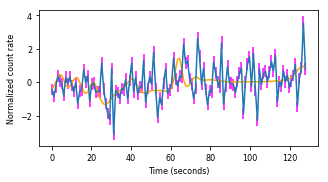

In [232]:
plt.rcParams['figure.figsize'] = (5.0, 2.5)
plt.rcParams.update({'font.size': 8})

plt.errorbar(np.linspace(0,128, 128), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
plt.plot(np.linspace(0,128, 128), reconstructions[plot_index], color="orange")
plt.ylabel("Normalized count rate", fontsize=8)
plt.xlabel("Time (seconds)", fontsize=8)
plt.show()
if plot_index>0:
    plot_index-=1

In [237]:
plt.rcParams['figure.figsize'] = (5.0, 2.5)
plt.rcParams.update({'font.size': 8})

for plot_index in range(plot_index):
    plt.errorbar(np.linspace(0,128, 128), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
    plt.plot(np.linspace(0,128, 128), reconstructions[plot_index], color="orange")
    plt.ylabel("Normalized count rate", fontsize=8)
    plt.xlabel("Time (seconds)", fontsize=8)

    plt.savefig("figures_1s_model/{}.png".format(ids[plot_index]), bbox_inches = 'tight',pad_inches = 0)
    plt.close()

# Load the model (4s cadence, 96 point segments)

In [238]:
weights_dir = "../../../model_weights/model_2020-11-22_07-55-14.h5" #exp160

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 96
intermediate_dim = 1024
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

# Load data (segments)

In [6]:
# segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
# errors_dir = '../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl'
segments_dir = '../../../data_GRS1915/509201_len96_stride8_4sec_cad_counts_errorfix.pkl'
errors_dir = '../../../data_GRS1915/509201_len96_stride8_4sec_cad_errors_errorfix.pkl'
ids_dir = '../../../data_GRS1915/509201_len96_stride8_4sec_cad_ids_errorfix.pkl'


with open(segments_dir, 'rb') as f:
    segments = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors = pickle.load(f)
with open(ids_dir, 'rb') as f:
    ids = pickle.load(f)


errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

# Try reconstruction (shape)

In [351]:
try_first_x = 100
reconstructions = np.zeros((try_first_x, segments.shape[1]))
for segment_index, segment in enumerate(segments[:try_first_x]):
    reconstructions[segment_index] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(errors[segment_index], axis=0)]).flatten()
    
plot_index = np.copy(try_first_x)-1

In [242]:
512*0.75

384.0

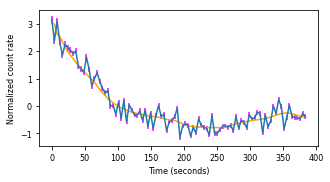

In [346]:
plt.rcParams['figure.figsize'] = (5.0, 2.5)
plt.rcParams.update({'font.size': 8})

plt.errorbar(np.linspace(0,384, original_dim), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
plt.plot(np.linspace(0,384, original_dim), reconstructions[plot_index], color="orange")
plt.ylabel("Normalized count rate", fontsize=8)
plt.xlabel("Time (seconds)", fontsize=8)
plt.show()
if plot_index>0:
    plot_index-=1

In [352]:
plt.rcParams['figure.figsize'] = (5.0, 2.5)
plt.rcParams.update({'font.size': 8})

for plot_index in range(plot_index):
    plt.errorbar(np.linspace(0,384, original_dim), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
    plt.plot(np.linspace(0,384, original_dim), reconstructions[plot_index], color="orange")
    plt.ylabel("Normalized count rate", fontsize=8)
    plt.xlabel("Time (seconds)", fontsize=8)

    plt.savefig("figures_96input_model/{}.png".format(ids[plot_index]), bbox_inches = 'tight',pad_inches = 0)
    plt.close()

# compare high and low cadence models in reconstruction of 128 data point segments

In [49]:
# with open('../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl', 'rb') as f:
#     segments = pickle.load(f)
# with open('../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl', 'rb') as f:
#     errors = pickle.load(f)
with open('../../../data_GRS1915/468202_len128_s2_4cad_ids_errorfix.pkl', 'rb') as f:
    ids_4s = pickle.load(f)

# errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
# segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment


with open('../../../data_GRS1915/468202_len128_s2_4cad_observation90-10split.pkl', 'rb') as f:
    split_segment_indices_4s = pickle.load(f)

In [50]:
ob_ids_4s = [x.split("_")[0] for x in np.take(ids_4s, split_segment_indices_4s[1])]
ob_ids_4s = np.unique(ob_ids_4s)

In [52]:
with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_ids_errorfix.pkl', 'rb') as f:
    ids_1s = pickle.load(f)

with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_observation75-25split.pkl', 'rb') as f:
    split_segment_indices_1s = pickle.load(f)

In [53]:
ob_ids_1s = [x.split("_")[0] for x in np.take(ids_1s, split_segment_indices_1s[1])]
ob_ids_1s = np.unique(ob_ids_1s)

In [54]:
val_obs_intersection = [x for x in ob_ids_4s if x in ob_ids_1s]

## test models with short cadence

In [165]:
with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_counts_errorfix.pkl', 'rb') as f:
    segments = pickle.load(f)
with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_errors_errorfix.pkl', 'rb') as f:
    errors = pickle.load(f)
    
errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

intersection_indices_1s = [n for n, x in enumerate(ids_1s) if x.split("_")[0] in val_obs_intersection]

In [56]:
weights_dir = "../../../model_weights/model_2020-11-24_17-50-16.h5" #exp160

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

In [61]:
intersection_indices_1s = np.array(intersection_indices_1s)
reconstructions = np.zeros((intersection_indices_1s.shape[0], segments.shape[1]))
for n, segment_index in enumerate(intersection_indices_1s):
    segment = segments[segment_index]
    error = errors[segment_index]
    reconstructions[n] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(error, axis=0)]).flatten()
    print(n)
    clear_output(wait=True)

13268


In [71]:
model_1s_data_1s_recos = np.copy(reconstructions)

In [159]:
np.sqrt(np.mean((model_1s_data_1s_recos-np.squeeze(np.take(segments, intersection_indices_1s, axis=0)))**2))

0.7602026226081587

In [137]:
np.mean(((model_1s_data_1s_recos-np.squeeze(np.take(segments, intersection_indices_1s, axis=0)))\
         /np.squeeze(np.take(errors, intersection_indices_1s, axis=0)))**2)


9.66333231878369

In [73]:
weights_dir = "../../../model_weights/model_2020-08-30_05-44-08.h5" #exp149

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

In [74]:
intersection_indices_1s = np.array(intersection_indices_1s)
reconstructions = np.zeros((intersection_indices_1s.shape[0], segments.shape[1]))
for n, segment_index in enumerate(intersection_indices_1s):
    segment = segments[segment_index]
    error = errors[segment_index]
    reconstructions[n] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(error, axis=0)]).flatten()
    print(n)
    clear_output(wait=True)

13268


In [75]:
model_4s_data_1s_recos = np.copy(reconstructions)

In [76]:
np.sqrt(np.mean((model_4s_data_1s_recos-np.squeeze(np.take(segments, intersection_indices_1s, axis=0)))**2))

0.7734437246390916

In [136]:
np.mean(((model_4s_data_1s_recos-np.squeeze(np.take(segments, intersection_indices_1s, axis=0)))\
         /np.squeeze(np.take(errors, intersection_indices_1s, axis=0)))**2)


13.51005910826197

In [168]:
plt.rcParams['figure.figsize'] = (10.0, 5)
plt.rcParams.update({'font.size': 8})

for n in range(200):
    plot_index= intersection_indices_1s[n]
    plt.errorbar(np.linspace(0,128, original_dim), segments[plot_index], yerr=errors[plot_index],color="orange", ecolor="grey", zorder=1)
    plt.plot(np.linspace(0,128, original_dim), model_1s_data_1s_recos[n], color="magenta", label="1s model", zorder =4, linestyle="-")
    plt.plot(np.linspace(0,128, original_dim), model_4s_data_1s_recos[n], color="black", label="4s model", zorder=5)
    model_1s_chi2 = np.mean(((model_1s_data_1s_recos[n]-np.squeeze(segments[plot_index]))/np.squeeze(errors[plot_index]))**2)
    model_4s_chi2 = np.mean(((model_4s_data_1s_recos[n]-np.squeeze(segments[plot_index]))/np.squeeze(errors[plot_index]))**2)

    axes = plt.gca()
    axes.text(0.3,0.99,r"${}$".format(model_1s_chi2), ha='right', va='top', transform=axes.transAxes, size=8, color="magenta")
    axes.text(0.3,0.95,r"${}$".format(model_4s_chi2), ha='right', va='top', transform=axes.transAxes, size=8, color="black")

    plt.legend(loc='upper right')
    plt.ylabel("Normalized count rate", fontsize=8)
    plt.xlabel("Time (seconds)", fontsize=8)
    plt.savefig("figures_1s_cad/{}.png".format(ids_1s[plot_index]), bbox_inches = 'tight',pad_inches = 0)
    plt.close()
# plt.show()

## test models with long cadence

In [171]:
with open('../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl', 'rb') as f:
    segments = pickle.load(f)
with open('../../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl', 'rb') as f:
    errors = pickle.load(f)

errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

with open('../../../data_GRS1915/468202_len128_s2_4cad_ids_errorfix.pkl', 'rb') as f:
    ids_4s = pickle.load(f)


with open('../../../data_GRS1915/468202_len128_s2_4cad_observation90-10split.pkl', 'rb') as f:
    split_segment_indices_4s = pickle.load(f)

intersection_indices_4s = [n for n, x in enumerate(ids_4s) if x.split("_")[0] in val_obs_intersection]

In [140]:
weights_dir = "../../../model_weights/model_2020-11-24_17-50-16.h5" #exp160

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

In [142]:
intersection_indices_4s = np.array(intersection_indices_4s)
reconstructions = np.zeros((intersection_indices_4s.shape[0], segments.shape[1]))
for n, segment_index in enumerate(intersection_indices_4s):
    segment = segments[segment_index]
    error = errors[segment_index]
    reconstructions[n] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(error, axis=0)]).flatten()
    print(n)
    clear_output(wait=True)

10417


In [144]:
model_1s_data_4s_recos = np.copy(reconstructions)

In [145]:
np.sqrt(np.mean((model_1s_data_4s_recos-np.squeeze(np.take(segments, intersection_indices_4s, axis=0)))**2))

0.7669494854828038

In [146]:
np.mean(((model_1s_data_4s_recos-np.squeeze(np.take(segments, intersection_indices_4s, axis=0)))\
         /np.squeeze(np.take(errors, intersection_indices_4s, axis=0)))**2)


81.34643392405323

In [147]:
weights_dir = "../../../model_weights/model_2020-08-30_05-44-08.h5" #exp149

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

In [148]:
intersection_indices_4s = np.array(intersection_indices_4s)
reconstructions = np.zeros((intersection_indices_4s.shape[0], segments.shape[1]))
for n, segment_index in enumerate(intersection_indices_4s):
    segment = segments[segment_index]
    error = errors[segment_index]
    reconstructions[n] = vae.predict([np.expand_dims(segment, axis=0), np.expand_dims(error, axis=0)]).flatten()
    print(n)
    clear_output(wait=True)

10417


In [149]:
model_4s_data_4s_recos = np.copy(reconstructions)

In [150]:
np.sqrt(np.mean((model_4s_data_4s_recos-np.squeeze(np.take(segments, intersection_indices_4s, axis=0)))**2))

0.7506812365442121

In [151]:
np.mean(((model_4s_data_4s_recos-np.squeeze(np.take(segments, intersection_indices_4s, axis=0)))\
         /np.squeeze(np.take(errors, intersection_indices_4s, axis=0)))**2)


46.42091874090363

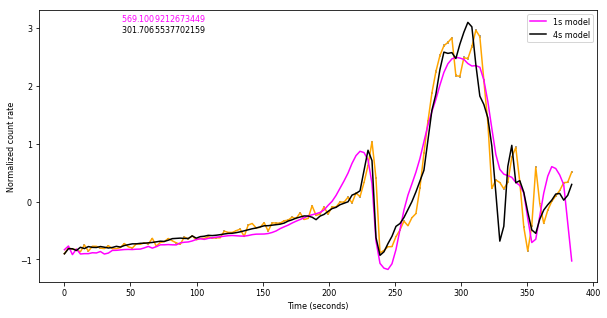

In [174]:
plt.rcParams['figure.figsize'] = (10.0, 5)
plt.rcParams.update({'font.size': 8})

n = 3341
plot_index= intersection_indices_4s[n]
plt.errorbar(np.linspace(0,384, original_dim), segments[plot_index], yerr=errors[plot_index],color="orange", ecolor="grey", zorder=1)
plt.plot(np.linspace(0,384, original_dim), model_1s_data_4s_recos[n], color="magenta", label="1s model", zorder =4, linestyle="-")
plt.plot(np.linspace(0,384, original_dim), model_4s_data_4s_recos[n], color="black", label="4s model", zorder=5)
model_1s_chi2 = np.mean(((model_1s_data_4s_recos[n]-np.squeeze(segments[plot_index]))/np.squeeze(errors[plot_index]))**2)
model_4s_chi2 = np.mean(((model_4s_data_4s_recos[n]-np.squeeze(segments[plot_index]))/np.squeeze(errors[plot_index]))**2)

axes = plt.gca()
axes.text(0.3,0.99,r"${}$".format(model_1s_chi2), ha='right', va='top', transform=axes.transAxes, size=8, color="magenta")
axes.text(0.3,0.95,r"${}$".format(model_4s_chi2), ha='right', va='top', transform=axes.transAxes, size=8, color="black")

plt.legend(loc='upper right')
plt.ylabel("Normalized count rate", fontsize=8)
plt.xlabel("Time (seconds)", fontsize=8)
plt.show()

In [175]:
plt.rcParams['figure.figsize'] = (10.0, 5)
plt.rcParams.update({'font.size': 8})

for n in range(200):
    plot_index= intersection_indices_4s[n]
    plt.errorbar(np.linspace(0,512, original_dim), segments[plot_index], yerr=errors[plot_index],color="orange", ecolor="grey", zorder=1)
    plt.plot(np.linspace(0,512, original_dim), model_1s_data_4s_recos[n], color="magenta", label="1s model", zorder =4, linestyle="-")
    plt.plot(np.linspace(0,512, original_dim), model_4s_data_4s_recos[n], color="black", label="4s model", zorder=5)
    model_1s_chi2 = np.mean(((model_1s_data_4s_recos[n]-np.squeeze(segments[plot_index]))/np.squeeze(errors[plot_index]))**2)
    model_4s_chi2 = np.mean(((model_4s_data_4s_recos[n]-np.squeeze(segments[plot_index]))/np.squeeze(errors[plot_index]))**2)

    axes = plt.gca()
    axes.text(0.3,0.99,r"${}$".format(model_1s_chi2), ha='right', va='top', transform=axes.transAxes, size=8, color="magenta")
    axes.text(0.3,0.95,r"${}$".format(model_4s_chi2), ha='right', va='top', transform=axes.transAxes, size=8, color="black")

    plt.legend(loc='upper right')
    plt.ylabel("Normalized count rate", fontsize=8)
    plt.xlabel("Time (seconds)", fontsize=8)
    plt.savefig("figures_4s_cad/{}.png".format(ids_4s[plot_index]), bbox_inches = 'tight',pad_inches = 0)
    plt.close()
# plt.show()

In [176]:
segments_dir = '{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir)
errors_dir = '{}/468202_len128_s2_4cad_errors_errorfix.pkl'.format(data_dir)
recos_dir = "{}/reconstructions_from_model_2020-08-30_11-42-38.pkl".format(data_dir)
ids_dir = '{}/468202_len128_s2_4cad_ids_errorfix.pkl'.format(data_dir)

with open(segments_dir, 'rb') as f:
    segments_old = pickle.load(f)
with open(errors_dir, 'rb') as f:
    errors_old = pickle.load(f)
with open(ids_dir, 'rb') as f:
    ids_old = pickle.load(f)
with open(recos_dir, 'rb') as f:
    recos_old = pickle.load(f)


recos_old= recos_old*np.std(segments_old, axis=1) + np.mean(segments_old, axis=1)

In [179]:
np.take(ids_old, intersection_indices_4s)

array(['50703-01-20-02_70', '10408-01-12-00_237', '10408-01-16-00_209',
       ..., '40116-01-02-03_197', '50703-01-14-02_92',
       '80701-01-34-00_118'], dtype='<U20')

In [181]:
ob_ids_4s

array(['10258-01-03-00', '10408-01-12-00', '10408-01-15-04',
       '10408-01-16-00', '10408-01-16-04', '10408-01-21-01',
       '10408-01-28-00', '10408-01-30-00', '10408-01-32-00',
       '10408-01-44-00', '20186-03-01-00', '20186-03-02-000',
       '20186-03-02-04', '20402-01-19-00', '20402-01-24-00',
       '20402-01-42-00', '20402-01-45-01', '20402-01-52-01',
       '20402-01-59-00', '30183-02-02-00', '30184-01-01-00',
       '30402-01-02-00', '30402-01-03-00', '30402-01-12-00',
       '30402-01-17-00', '30703-01-05-00', '30703-01-14-00',
       '30703-01-19-00', '30703-01-22-01', '30703-01-24-00',
       '30703-01-40-00', '30703-01-40-01', '40116-01-02-03',
       '40116-01-03-00', '40116-01-07-01', '40403-01-05-02',
       '40403-01-06-01', '40403-01-08-00', '40702-01-01-00',
       '40703-01-08-00', '40703-01-14-01', '40703-01-29-00',
       '40703-01-34-02', '40703-01-36-02', '40703-01-44-03',
       '40703-01-51-01', '50125-01-01-01', '50125-01-02-02',
       '50405-01-02-02'

# Try GMM centroid reconstructions with 4s 128p model

In [2]:
weights_dir = "../../../model_weights/model_2020-08-30_05-44-08.h5" #exp149

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 16

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

# Load data (segments)

In [2]:
GMmeans_dir = "{}/GMM_122comp_20d_alldata_model_2020-08-30_11-42-38_means.pkl".format(data_dir)
with open(GMmeans_dir, 'rb') as f:
    GMM_means = pickle.load(f)
    
GMcovs_dir = "{}/GMM_122comp_20d_alldata_model_2020-08-30_11-42-38_covariances.pkl".format(data_dir)
with open(GMcovs_dir, 'rb') as f:
    GMM_covariances = pickle.load(f)

# Try reconstruction (shape)

In [8]:
trained_decoder = tf.keras.Model(inputs=vae.get_layer("decoder").input, outputs=vae.get_layer("decoder").output)
generated_samples = np.zeros((122, 128))
for n_component, component_point in enumerate(GMM_means):
    prediction = trained_decoder.predict(np.expand_dims(component_point[:16], axis=0))
    generated_samples[n_component, :] = prediction.flatten()

    print(n_component)
    clear_output(wait=True)


121


In [194]:
plot_index=121

In [56]:
periodic_flare = [6,10,16,21,22,24,37,38,41,45,56,57,59,63,79,81,82,83,90,94,96,105,108,115,119,121]# periodic flare
mid_random = [0,32,40,50,60,73,100,103,110,113,118]# mid random
low_random = [1,2,4,5,7,12,14,18,27, 30,31,47,49,51,54,67,71,76,80,99,106,109]# low random
positive_gradient = [8,11, 52,66,68,117]# +ve gradient
square_wave = [43,88,89,98,114]# square wave

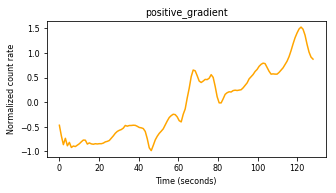

In [248]:
plt.rcParams['figure.figsize'] = (5.0, 2.5)
plt.rcParams.update({'font.size': 8})

# plt.errorbar(np.linspace(0,128, 128), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
subset_names = ["periodic_flare", "mid_random", "low_random", "positive_gradient", "square_wave"]
plot_subset="?"
for n_subset, subset in enumerate([periodic_flare, mid_random, low_random, positive_gradient, square_wave]):
    if plot_index in subset:
        plot_subset = subset_names[n_subset]
        break

plt.plot(np.linspace(0,128, 128), generated_samples[plot_index], color="orange")
plt.ylabel("Normalized count rate", fontsize=8)
plt.xlabel("Time (seconds)", fontsize=8)
plt.title(plot_subset)
plt.show()
if plot_index>0:
    plot_index-=1

In [193]:
plot_index

0

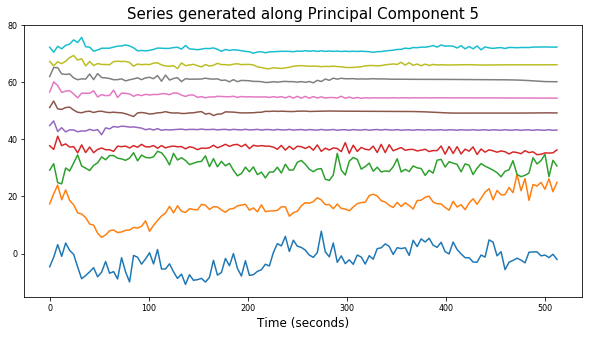

In [128]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams.update({'font.size': 8})
plot_index = 0
PC_ind = 4
# plt.errorbar(np.linspace(0,512, 128), segments[plot_index], yerr=errors[plot_index], ecolor="magenta")
offset = 0
for n_lc, lc in enumerate(generated_samples[PC_ind]):
    if n_lc>0:
        offset += np.max(generated_samples[PC_ind, n_lc])-np.min(generated_samples[PC_ind, n_lc])
    plt.plot(np.linspace(0,512, 128), generated_samples[PC_ind, n_lc]+offset)
# plt.ylabel("Normalized count rate", fontsize=12)
plt.xlabel("Time (seconds)", fontsize=12)
plt.title("Series generated along Principal Component {}".format(PC_ind+1), fontsize=15)
plt.show()
if plot_index>0:
    plot_index-=1

In [26]:
from sklearn.cluster import DBSCAN
import numpy as np
for eps in np.linspace(2,3,500):
    clustering = DBSCAN(eps=eps, min_samples=2, metric="euclidean").fit(GMM_means) #, metric_params={"V": GMM_covariances} mahalanobis

    print(eps, np.unique(clustering.labels_, return_counts=True))

2.0 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.002004008016032 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.004008016032064 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.006012024048096 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0080160320641283 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0100200400801604 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.012024048096192 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0140280561122244 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0160320641282565 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0180360721442887 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0200400801603204 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0220440881763526 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.024048096192385 (array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))
2.0260

In [13]:
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([61, 54,  3,  2,  2]))

# Load the model (1s cadence, 128 point segments) 20 latent variables

In [3]:
with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_counts_errorfix.pkl', 'rb') as f:
    segments = pickle.load(f)
with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_errors_errorfix.pkl', 'rb') as f:
    errors = pickle.load(f)
    
errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment

# intersection_indices_1s = [n for n, x in enumerate(ids_1s) if x.split("_")[0] in val_obs_intersection]

In [4]:
weights_dir = "../../../model_weights/model_2020-12-02_15-00-24.h5" #exp166

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example"""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


original_dim = 128
intermediate_dim = 1024
latent_dim = 20

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,1), name='encoder_input')
input_err = Input(shape=(original_dim,1))
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=False)(original_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name='encoder')

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.RepeatVector(original_dim)(latent_inputs)
x = layers.CuDNNLSTM(intermediate_dim, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=[original_inputs, input_err], outputs=outputs, name='vae')

vae.load_weights(weights_dir)

# Encode the data set (shape)

In [5]:
trained_encoder = tf.keras.Model(inputs=vae.input, outputs=[vae.get_layer("z_mean").output, vae.get_layer("z_log_var").output])
segment_encoding = np.zeros((segments.shape[0], 2, 20))
for seg_ind, seg in enumerate(segments):
    prediction = trained_encoder.predict([np.expand_dims(seg, axis=0), np.expand_dims(errors[seg_ind], axis=0)])
    segment_encoding[seg_ind][0] = prediction[0].flatten()
    segment_encoding[seg_ind][1] = prediction[1].flatten()
    print(seg_ind)
    clear_output(wait=True)
    

594482


In [7]:
segments_dir = "/594483_len128_stride8_1sec_cad_counts_errorfix.pkl"

In [8]:
segment_encoding_dir = '../../../data_GRS1915/segment_encoding_{}_segments_{}.pkl'.format(weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'wb') as f:
    pickle.dump(segment_encoding, f)
print("Encodings saved to: ", segment_encoding_dir)

Encodings saved to:  ../../../data_GRS1915/segment_encoding_model_2020-12-02_15-00-24_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl


In [10]:
segment_encoding.shape

(594483, 2, 20)

# Use GMM to classify observations

 - reuse code from cluster_analysis_new.ipynb

## 250 component GMM

In [15]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
import pandas as pd
# from sklearn.cluster import OPTICS

from scipy.stats import zscore

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


from sklearn.mixture import GaussianMixture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [3]:
with open('{}/594483_len128_stride8_1sec_cad_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)

In [35]:
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs


compar_results = np.zeros((2,1))


test_sets = []
train_sets = []
# split the observations into test and training sets
for test_iter in range(1000):
    test_set = []
    train_set = []
    
    # split is stratified, so done separately for each class
    for class_name in ["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"]:

        class_obs_all = inv_ob_state[class_name] # all labeled observation IDs of this class
        # exclude observations which did not produce any light curve segments
        class_obs = []
        for ob in class_obs_all:
            if ob in seg_ObIDs: # seg_ObIDs contains observation ID for each of the 468202 light curve segments
                class_obs.append(ob)
        
        # pick 1/3 of observations for the test set (previously replace=True was set!!!!)
        test_obs = np.random.choice(class_obs, size=int(np.ceil(len(class_obs)/3)), replace=False) 
        
        if len(test_obs) == 0:
            print(class_name)
        
        # use the remaining observations as training set
        train_obs = []
        for ob in class_obs:
            if ob not in test_obs:
                train_obs.append(ob)
        test_set.append(test_obs)
        train_set.append(train_obs)

    test_set=np.hstack(test_set)
    train_set=np.hstack(train_set)
    test_sets.append(test_set)
    train_sets.append(train_set)


In [6]:
with open('{}/GMM_250comps_model_2020-12-02_15-00-24_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    GMmodel = pickle.load(f)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [10]:
# load light curve segments
with open('{}/594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-02_15-00-24.h5"
segments_dir = '../../../data_GRS1915/594483_len128_stride8_1sec_cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [468202, 20]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [11]:
shape_moments_GMM250_labels = GMmodel.predict(shape_moments)

In [12]:
# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

In [13]:
# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_500 == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_250 = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_250[ObID] = [shape_moments_GMM250_labels[ind] for ind in Indices]

In [16]:
# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_250 = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_250),len(np.unique(shape_moments_GMM250_labels)))), index=np.unique(seg_ObIDs), columns=list(range(250)), dtype=int)

In [17]:
# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_250.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_250.loc[ObID][comp_id] = comp_count
obs_component_counts_df_250

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
10258-01-01-00,0,0,0,2,12,0,0,0,0,0,...,0,11,0,0,0,0,0,0,4,0
10258-01-02-00,0,0,0,8,23,0,7,0,0,0,...,0,37,0,0,0,0,0,0,34,0
10258-01-03-00,0,0,7,7,5,0,42,0,0,0,...,0,21,0,0,0,0,27,0,10,0
10258-01-04-00,0,0,356,0,0,0,26,0,0,0,...,0,6,0,0,0,0,120,0,4,0
10258-01-05-00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0,0,18,1,0,0,0,0,0,0,...,0,1,0,0,0,0,10,0,0,0
96701-01-51-00,0,0,12,0,0,0,2,0,0,0,...,0,0,0,0,0,0,28,0,1,0
96701-01-51-01,0,0,16,0,1,0,1,0,1,0,...,0,1,0,0,0,0,20,0,1,0
96701-01-52-00,0,0,22,1,0,0,4,0,0,0,...,0,3,1,0,0,0,20,0,0,0


In [20]:
obs_component_counts_df_250.iloc[:,:250].div(np.sum(obs_component_counts_df_250.iloc[:,:250], axis=1), axis="rows")
obs_component_counts_df_250["Class"] = "Unknown"

In [22]:
for k,v in ob_state.items():
    if str(k) in obs_component_counts_df_250.index.values:
        obs_component_counts_df_250.loc[str(k), "Class"] = v

In [25]:
np.unique(obs_component_counts_df_250.Class)

array(['Unknown', 'alpha', 'beta', 'chi', 'delta', 'eta', 'gamma',
       'kappa', 'lambda', 'mu', 'nu', 'omega', 'phi', 'rho', 'theta'],
      dtype=object)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       alpha       1.00      0.67      0.80         3
        beta       1.00      1.00      1.00         6
         chi       0.90      1.00      0.95        26
       delta       0.89      1.00      0.94         8
         eta       0.00      0.00      0.00         1
       gamma       0.60      0.75      0.67         4
       kappa       1.00      0.75      0.86         4
      lambda       1.00      0.50      0.67         2
          mu       1.00      0.67      0.80         3
          nu       1.00      1.00      1.00         1
       omega       0.00      0.00      0.00         1
         phi       0.75      1.00      0.86         3
         rho       1.00      0.86      0.92         7
       theta       0.88      1.00      0.93         7

    accuracy                           0.89        76
   macro avg       0.79      0.73      0.74        76
weighted avg       0.88      0.89      0.88        76



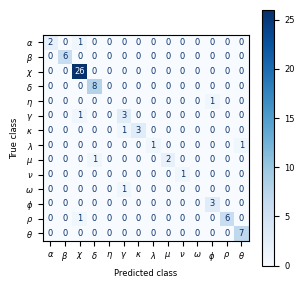

In [28]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.32, 3.32)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})

experiment_list = [

    [obs_component_counts_df_250, "Classification with proportional make up of observations in terms of 114 Gaussian mixture components"],

]

reports = []
# for test_set, train_set in zip(test_sets, train_sets):
n=0#3
test_set=test_sets[n]
train_set=train_sets[n]
for dataset, title in experiment_list:
    SVC_clf = RandomForestClassifier(random_state=0, class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:250], dataset["Class"].loc[train_set])
    if title[-8:] == "balanced":
        SVC_clf = SVC(gamma="auto", class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:250], dataset["Class"].loc[train_set])

    preds = SVC_clf.predict(dataset.loc[test_set].iloc[:,:250])
#         reports.append(classification_report(dataset["Class"].loc[test_set], preds))
    reports.append(( precision_recall_fscore_support(dataset["Class"].loc[test_set], preds,zero_division=0, average="weighted"),precision_recall_fscore_support(dataset["Class"].loc[test_set], preds,zero_division=0, average="macro"), accuracy_score(dataset["Class"].loc[test_set], preds)))
#             precision_recall_fscore_support(dataset["Class"].loc[test_set], preds, average="macro"), precision_recall_fscore_support(dataset["Class"].loc[test_set], preds, average="micro")))
#     print("{}".format(title))
    print(classification_report(dataset["Class"].loc[test_set], preds))



    disp = plot_confusion_matrix(SVC_clf, dataset.loc[test_set].iloc[:,:250], dataset["Class"].loc[test_set],
                             cmap=plt.cm.Blues,
                             normalize=None)
#     disp.ax_.set_title("{}".format(title))
    disp.ax_.set_xlabel("Predicted class")
    disp.ax_.set_ylabel("True class")
    disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(dataset["Class"])[1:]])
    disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(dataset["Class"])[1:]])
    plt.savefig('figures/classification_matrix.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

    plt.show()


In [36]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6.97, 6.97)
plt.rcParams.update({'font.size': 6})

experiment_list = [

    [obs_component_counts_df_250, "Classification with proportional make up of observations in terms of 114 Gaussian mixture components"],

]


reports = []
for test_set, train_set in zip(test_sets, train_sets):

    for dataset, title in experiment_list:
        SVC_clf = RandomForestClassifier(random_state=0, class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:250], [ob_state[x] for x in train_set])
        if title[-8:] == "balanced":
            SVC_clf = SVC(gamma="auto", class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:250], [ob_state[x] for x in train_set])

        preds = SVC_clf.predict(dataset.loc[test_set].iloc[:,:250])
#         reports.append(classification_report(dataset["Class"].loc[test_set], preds))
        reports.append(( precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="weighted"),precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="macro"), accuracy_score([ob_state[x] for x in test_set], preds)))
#             precision_recall_fscore_support(dataset["Class"].loc[test_set], preds, average="macro"), precision_recall_fscore_support(dataset["Class"].loc[test_set], preds, average="micro")))
#         print("{}".format(title))
#         print(classification_report(dataset["Class"].loc[test_set], preds))



#         disp = plot_confusion_matrix(SVC_clf, dataset.loc[test_set].iloc[:,:250], dataset["Class"].loc[test_set],
#                                  cmap=plt.cm.Blues,
#                                  normalize=None)
    #     disp.ax_.set_title("{}".format(title))
#         disp.ax_.set_xlabel("Predicted class")
#         disp.ax_.set_ylabel("True class")
    #     plt.savefig('figures/classification_matrix.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

    #     plt.show()
    
    

In [37]:
accuracies = []
f1s_weighted = []
f1s_average = []
for report in reports:# weighted(precision, recall, f1), accuracy
    accuracies.append(report[2])
    f1s_weighted.append(report[0][2])
#     f1s_average.append(report[1][2])

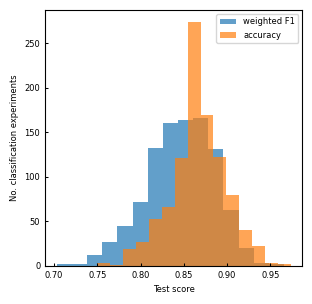

In [40]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(f1s_weighted, bins=15, label="weighted F1", alpha=0.7)
plt.hist(accuracies, bins=15, label="accuracy", alpha=0.7)
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")
# plt.title("Classification with 4 chi subclasses")


# plt.savefig('figures/classification_histogram_chi_subclasses.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [39]:
print(np.mean(f1s_weighted), np.mean(accuracies))

0.8458781014206539 0.8670789473684211


In [41]:
print(np.std(f1s_weighted), np.std(accuracies))

0.03895697390720147 0.033296483555692716


In [55]:
def test_GMM_in_classification(GMmodel, data):
    comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = GMmodel.predict(data)
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_500 == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=list(range(comp)), dtype=int)
    
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    obs_component_counts_df_comp
    
    obs_component_counts_df_comp.iloc[:,:comp].div(np.sum(obs_component_counts_df_comp.iloc[:,:comp], axis=1), axis="rows")
    obs_component_counts_df_comp["Class"] = "Unknown"
    
    for k,v in ob_state.items():
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            

    experiment_list = [

        [obs_component_counts_df_comp, "Title"],

    ]
    reports = []
    for test_set, train_set in zip(test_sets, train_sets):

        for dataset, title in experiment_list:
            SVC_clf = RandomForestClassifier(random_state=0, class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:comp], [ob_state[x] for x in train_set])
            if title[-8:] == "balanced":
                SVC_clf = SVC(gamma="auto", class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:comp], [ob_state[x] for x in train_set])

            preds = SVC_clf.predict(dataset.loc[test_set].iloc[:,:comp])
    #         reports.append(classification_report(dataset["Class"].loc[test_set], preds))
            reports.append(( precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="weighted"),precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="macro"), accuracy_score([ob_state[x] for x in test_set], preds)))

    
    accuracies = []
    f1s_weighted = []
    for report in reports:# weighted(precision, recall, f1), accuracy
        accuracies.append(report[2])
        f1s_weighted.append(report[0][2])

    return accuracies, f1s_weighted

## 260 components GMM

In [10]:
# load light curve segments
with open('{}/594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-02_15-00-24.h5"
segments_dir = '../../../data_GRS1915/594483_len128_stride8_1sec_cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [468202, 20]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [60]:
with open('{}/GMM_260comps_model_2020-12-02_15-00-24_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    GMmodel = pickle.load(f)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [61]:
accuracies, f1s_weighted = test_GMM_in_classification(GMmodel, shape_moments)

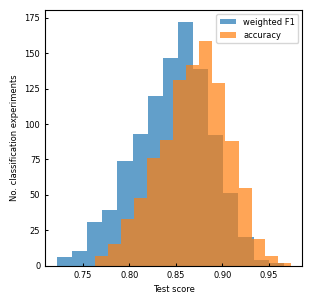

In [62]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(f1s_weighted, bins=15, label="weighted F1", alpha=0.7)
plt.hist(accuracies, bins=15, label="accuracy", alpha=0.7)
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")
# plt.title("Classification with 4 chi subclasses")


# plt.savefig('figures/classification_histogram_chi_subclasses.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [63]:
print(np.mean(f1s_weighted), np.mean(accuracies))

0.8467827310395757 0.8686447368421052


In [64]:
print(np.std(f1s_weighted), np.std(accuracies))

0.04054625563707935 0.03450960111696566


## 300 component GMM

In [65]:
with open('{}/GMM_300comps_model_2020-12-02_15-00-24_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    GMmodel = pickle.load(f)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [56]:
accuracies, f1s_weighted = test_GMM_in_classification(GMmodel, shape_moments)

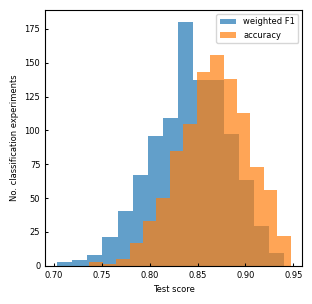

In [57]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(f1s_weighted, bins=15, label="weighted F1", alpha=0.7)
plt.hist(accuracies, bins=15, label="accuracy", alpha=0.7)
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")
# plt.title("Classification with 4 chi subclasses")


# plt.savefig('figures/classification_histogram_chi_subclasses.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [58]:
print(np.mean(f1s_weighted), np.mean(accuracies))

0.8423335692190473 0.8654605263157894


In [59]:
print(np.std(f1s_weighted), np.std(accuracies))

0.04000186212342697 0.03436799538303332


## merge components in 300 GMM and test

In [69]:
from scipy.spatial import distance
GM_comp_mahal_distances = np.zeros((300,300))
for comp1_ind, comp1 in enumerate(GMmodel.means_):
    for comp2_ind, comp2 in enumerate(GMmodel.means_):
        GM_comp_mahal_distances[comp1_ind, comp2_ind] = distance.mahalanobis(comp1, comp2, np.linalg.inv(GMmodel.covariances_[comp2_ind]))
        print(comp1_ind, comp2_ind)
        clear_output(wait=True)

299 299


In [81]:
np.sum((GM_comp_mahal_distances<3)&(GM_comp_mahal_distances>0))

722

In [88]:
np.arange(300)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [87]:
couples = np.array(np.where(((np.triu(GM_comp_mahal_distances)<3)&(np.triu(GM_comp_mahal_distances)>0))
      &(np.triu(GM_comp_mahal_distances.T)<3)&(np.triu(GM_comp_mahal_distances.T)>0))).T

In [93]:
l = [str(c) for c in list(range(300))]
for couple in couples:
    l.append([str(c) for c in couple])
    
import networkx 
from networkx.algorithms.components.connected import connected_components


def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(l)
print(connected_components(G))

<generator object connected_components at 0x7fd2d78b6f20>


In [98]:
obs_component_counts_df_250[5]

10258-01-01-00    0
10258-01-02-00    0
10258-01-03-00    0
10258-01-04-00    0
10258-01-05-00    0
                 ..
96701-01-50-01    0
96701-01-51-00    0
96701-01-51-01    0
96701-01-52-00    0
96701-01-52-01    0
Name: 5, Length: 1775, dtype: int64

In [103]:
for connection in connected_components(G):
    connection_int=[int(node) for node in connection]
    obs_component_counts_df_250[connection_int[0]] = obs_component_counts_df_250[connection_int].sum(axis=1)
    obs_component_counts_df_250.drop(connection_int[1:], axis=1)
    break
    print(x)

10258-01-01-00     28
10258-01-02-00     92
10258-01-03-00    130
10258-01-04-00    391
10258-01-05-00     17
                 ... 
96701-01-50-01     27
96701-01-51-00     17
96701-01-51-01     26
96701-01-52-00     49
96701-01-52-01     22
Length: 1775, dtype: int64


In [105]:
def test_frankGMM_in_classification(GMmodel, data):
    comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = GMmodel.predict(data)
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_500 == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=list(range(comp)), dtype=int)
    
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    obs_component_counts_df_comp
    
    
    for connection in connected_components(G):
        connection_int=[int(node) for node in connection]
        obs_component_counts_df_comp[connection_int[0]] = obs_component_counts_df_comp[connection_int].sum(axis=1)
        obs_component_counts_df_comp.drop(connection_int[1:], axis=1)
    
    
    obs_component_counts_df_comp.iloc[:,:comp].div(np.sum(obs_component_counts_df_comp.iloc[:,:comp], axis=1), axis="rows")
    obs_component_counts_df_comp["Class"] = "Unknown"
    
    for k,v in ob_state.items():
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            

    experiment_list = [

        [obs_component_counts_df_comp, "Title"],

    ]
    reports = []
    for test_set, train_set in zip(test_sets, train_sets):

        for dataset, title in experiment_list:
            SVC_clf = RandomForestClassifier(random_state=0, class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:comp], [ob_state[x] for x in train_set])
            if title[-8:] == "balanced":
                SVC_clf = SVC(gamma="auto", class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:comp], [ob_state[x] for x in train_set])

            preds = SVC_clf.predict(dataset.loc[test_set].iloc[:,:comp])
    #         reports.append(classification_report(dataset["Class"].loc[test_set], preds))
            reports.append(( precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="weighted"),precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="macro"), accuracy_score([ob_state[x] for x in test_set], preds)))

    
    accuracies = []
    f1s_weighted = []
    for report in reports:# weighted(precision, recall, f1), accuracy
        accuracies.append(report[2])
        f1s_weighted.append(report[0][2])

    return accuracies, f1s_weighted

In [106]:
accuracies, f1s_weighted = test_frankGMM_in_classification(GMmodel, shape_moments)

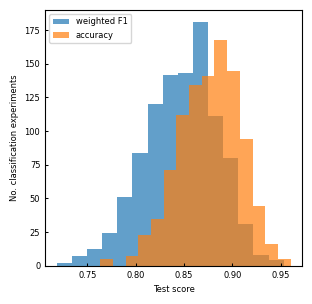

In [107]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(f1s_weighted, bins=15, label="weighted F1", alpha=0.7)
plt.hist(accuracies, bins=15, label="accuracy", alpha=0.7)
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")
# plt.title("Classification with 4 chi subclasses")


# plt.savefig('figures/classification_histogram_chi_subclasses.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [108]:
print(np.mean(f1s_weighted), np.mean(accuracies))

0.847070323118772 0.8700263157894738


In [109]:
print(np.std(f1s_weighted), np.std(accuracies))

0.03729576301100306 0.031576524029824665


## merged 260

In [110]:
with open('{}/GMM_260comps_model_2020-12-02_15-00-24_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    GMmodel = pickle.load(f)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [112]:
from scipy.spatial import distance
GM_comp_mahal_distances = np.zeros((GMmodel.means_.shape[0],GMmodel.means_.shape[0]))
for comp1_ind, comp1 in enumerate(GMmodel.means_):
    for comp2_ind, comp2 in enumerate(GMmodel.means_):
        GM_comp_mahal_distances[comp1_ind, comp2_ind] = distance.mahalanobis(comp1, comp2, np.linalg.inv(GMmodel.covariances_[comp2_ind]))
        print(comp1_ind, comp2_ind)
        clear_output(wait=True)

259 259


In [113]:
couples = np.array(np.where(((np.triu(GM_comp_mahal_distances)<3)&(np.triu(GM_comp_mahal_distances)>0))
      &(np.triu(GM_comp_mahal_distances.T)<3)&(np.triu(GM_comp_mahal_distances.T)>0))).T

In [114]:
l = [str(c) for c in list(range(GMmodel.means_.shape[0]))]
for couple in couples:
    l.append([str(c) for c in couple])
    
import networkx 
from networkx.algorithms.components.connected import connected_components


def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(l)
print(connected_components(G))

<generator object connected_components at 0x7fd2d74be970>


In [115]:
def test_frankGMM_in_classification(GMmodel, data):
    comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = GMmodel.predict(data)
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_500 == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=list(range(comp)), dtype=int)
    
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    obs_component_counts_df_comp
    
    # merge components
    for connection in connected_components(G):
        connection_int=[int(node) for node in connection]
        obs_component_counts_df_comp[connection_int[0]] = obs_component_counts_df_comp[connection_int].sum(axis=1)
        obs_component_counts_df_comp.drop(connection_int[1:], axis=1)
    
    
    obs_component_counts_df_comp.iloc[:,:comp].div(np.sum(obs_component_counts_df_comp.iloc[:,:comp], axis=1), axis="rows")
    obs_component_counts_df_comp["Class"] = "Unknown"
    
    for k,v in ob_state.items():
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            

    experiment_list = [

        [obs_component_counts_df_comp, "Title"],

    ]
    reports = []
    for test_set, train_set in zip(test_sets, train_sets):

        for dataset, title in experiment_list:
            SVC_clf = RandomForestClassifier(random_state=0, class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:comp], [ob_state[x] for x in train_set])
            if title[-8:] == "balanced":
                SVC_clf = SVC(gamma="auto", class_weight="balanced").fit(dataset.loc[train_set].iloc[:,:comp], [ob_state[x] for x in train_set])

            preds = SVC_clf.predict(dataset.loc[test_set].iloc[:,:comp])
    #         reports.append(classification_report(dataset["Class"].loc[test_set], preds))
            reports.append(( precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="weighted"),precision_recall_fscore_support([ob_state[x] for x in test_set], preds,zero_division=0, average="macro"), accuracy_score([ob_state[x] for x in test_set], preds)))

    
    accuracies = []
    f1s_weighted = []
    for report in reports:# weighted(precision, recall, f1), accuracy
        accuracies.append(report[2])
        f1s_weighted.append(report[0][2])

    return accuracies, f1s_weighted

In [116]:
accuracies, f1s_weighted = test_frankGMM_in_classification(GMmodel, shape_moments)

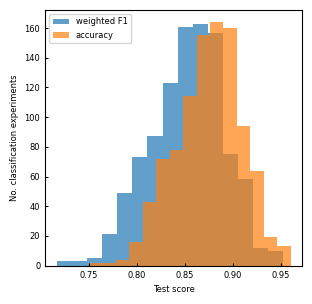

In [117]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(f1s_weighted, bins=15, label="weighted F1", alpha=0.7)
plt.hist(accuracies, bins=15, label="accuracy", alpha=0.7)
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")
# plt.title("Classification with 4 chi subclasses")


# plt.savefig('figures/classification_histogram_chi_subclasses.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [118]:
print(np.mean(f1s_weighted), np.mean(accuracies))

0.8524320631151057 0.8737236842105264


In [119]:
print(np.std(f1s_weighted), np.std(accuracies))

0.03812452219174885 0.03227465827056879


## merged 260, merge within 4 sigma

In [110]:
with open('{}/GMM_260comps_model_2020-12-02_15-00-24_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    GMmodel = pickle.load(f)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [112]:
from scipy.spatial import distance
GM_comp_mahal_distances = np.zeros((GMmodel.means_.shape[0],GMmodel.means_.shape[0]))
for comp1_ind, comp1 in enumerate(GMmodel.means_):
    for comp2_ind, comp2 in enumerate(GMmodel.means_):
        GM_comp_mahal_distances[comp1_ind, comp2_ind] = distance.mahalanobis(comp1, comp2, np.linalg.inv(GMmodel.covariances_[comp2_ind]))
        print(comp1_ind, comp2_ind)
        clear_output(wait=True)

259 259


In [120]:
separation=4
couples = np.array(np.where(((np.triu(GM_comp_mahal_distances)<separation)&(np.triu(GM_comp_mahal_distances)>0))
      &(np.triu(GM_comp_mahal_distances.T)<separation)&(np.triu(GM_comp_mahal_distances.T)>0))).T

In [125]:
l = [str(c) for c in list(range(GMmodel.means_.shape[0]))]
for couple in couples:
    l.append([str(c) for c in couple])
    
import networkx 
from networkx.algorithms.components.connected import connected_components


def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(l)
print(connected_components(G))

<generator object connected_components at 0x7fd2d74beb30>


In [126]:
for i in connected_components(G):
    print(len(i))

104
6
2
4


In [128]:
accuracies, f1s_weighted = test_frankGMM_in_classification(GMmodel, shape_moments)

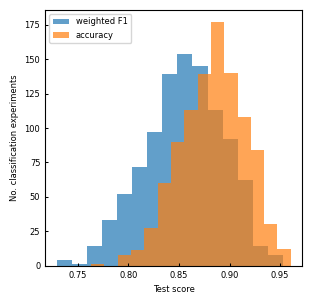

In [129]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(f1s_weighted, bins=15, label="weighted F1", alpha=0.7)
plt.hist(accuracies, bins=15, label="accuracy", alpha=0.7)
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")
# plt.title("Classification with 4 chi subclasses")


# plt.savefig('figures/classification_histogram_chi_subclasses.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [130]:
print(np.mean(f1s_weighted), np.mean(accuracies))

0.8553564357881487 0.8769473684210527


In [131]:
print(np.std(f1s_weighted), np.std(accuracies))

0.03808205698821537 0.031960675282961974


## merged 260, merge within 5 sigma

In [110]:
with open('{}/GMM_260comps_model_2020-12-02_15-00-24_segments_594483_len128_stride8_1sec_cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    GMmodel = pickle.load(f)

/home/jkok1g14/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [112]:
from scipy.spatial import distance
GM_comp_mahal_distances = np.zeros((GMmodel.means_.shape[0],GMmodel.means_.shape[0]))
for comp1_ind, comp1 in enumerate(GMmodel.means_):
    for comp2_ind, comp2 in enumerate(GMmodel.means_):
        GM_comp_mahal_distances[comp1_ind, comp2_ind] = distance.mahalanobis(comp1, comp2, np.linalg.inv(GMmodel.covariances_[comp2_ind]))
        print(comp1_ind, comp2_ind)
        clear_output(wait=True)

259 259


In [132]:
separation=5
couples = np.array(np.where(((np.triu(GM_comp_mahal_distances)<separation)&(np.triu(GM_comp_mahal_distances)>0))
      &(np.triu(GM_comp_mahal_distances.T)<separation)&(np.triu(GM_comp_mahal_distances.T)>0))).T

In [133]:
l = [str(c) for c in list(range(GMmodel.means_.shape[0]))]
for couple in couples:
    l.append([str(c) for c in couple])
    
import networkx 
from networkx.algorithms.components.connected import connected_components


def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(l)
print(connected_components(G))

<generator object connected_components at 0x7fd2d980dc10>


In [135]:
no_clusters = GMmodel.means_.shape[0]
for i in connected_components(G):
    no_clusters-=(len(i)-1)
print(no_clusters)

123


In [136]:
accuracies, f1s_weighted = test_frankGMM_in_classification(GMmodel, shape_moments)

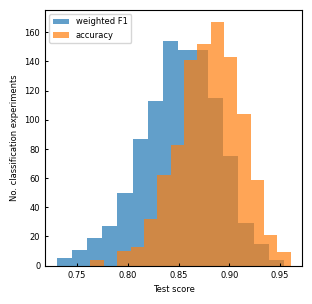

In [137]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(f1s_weighted, bins=15, label="weighted F1", alpha=0.7)
plt.hist(accuracies, bins=15, label="accuracy", alpha=0.7)
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")
# plt.title("Classification with 4 chi subclasses")


# plt.savefig('figures/classification_histogram_chi_subclasses.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [138]:
print(np.mean(f1s_weighted), np.mean(accuracies))

0.851068236391894 0.8735131578947368


In [139]:
print(np.std(f1s_weighted), np.std(accuracies))

0.03787203355184634 0.03164256475749292


In [141]:
# with open('../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl', 'rb') as f:
#     segments = pickle.load(f)
# with open('../../data_GRS1915/468202_len128_s2_4cad_errors_errorfix.pkl', 'rb') as f:
#     errors = pickle.load(f)
with open('../../../data_GRS1915/468202_len128_s2_4cad_ids_errorfix.pkl', 'rb') as f:
    ids_4s = pickle.load(f)

# errors = ((errors)/np.expand_dims(np.std(segments, axis=1), axis=1)).astype(np.float32)
# segments = zscore(segments, axis=1).astype(np.float32)  # standardize per segment


# with open('../../../data_GRS1915/468202_len128_s2_4cad_observation90-10split.pkl', 'rb') as f:
#     split_segment_indices_4s = pickle.load(f)

In [142]:
ob_ids_4s = [x.split("_")[0] for x in ids_4s]
ob_ids_4s = np.unique(ob_ids_4s)

In [143]:
len(ob_ids_4s)

1738

In [ ]:
ob_ids_1s

In [144]:
with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_ids_errorfix.pkl', 'rb') as f:
    ids_1s = pickle.load(f)

# with open('../../../data_GRS1915/594483_len128_stride8_1sec_cad_observation75-25split.pkl', 'rb') as f:
#     split_segment_indices_1s = pickle.load(f)

In [145]:
ob_ids_1s = [x.split("_")[0] for x in ids_1s]
ob_ids_1s = np.unique(ob_ids_1s)

In [146]:
len(ob_ids_1s)

1775

In [149]:
len(ob_state.keys())

216

In [151]:
len([i for i in ob_ids_1s if i in ob_state.keys()])

215